Six-Hump Camel synthetic function:

GP ERM versus STP nu = 3 ERM (winner)

https://www.sfu.ca/~ssurjano/camel6.html

In [1]:
pip install pyGPGO


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
### Import modules:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import random
import warnings

from pyGPGO.logger import EventLogger
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess, logpdf
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from collections import OrderedDict
from joblib import Parallel, delayed
from numpy.linalg import slogdet, inv, cholesky, solve
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.special import gamma
from scipy.stats import norm, t
from matplotlib.pyplot import rc

rc('text', usetex=False)
plt.rcParams['text.latex.preamble']=[r'\usepackage{amsmath}']
plt.rcParams['text.latex.preamble'] = [r'\boldmath']

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [3]:
### Inputs:

obj_func = 'SixHumpCamel'
n_test = 500 # test points
eps = 1e-08
df = 3 # nu

util_gp = 'RegretMinimized'
util_stp = 'tRegretMinimized'
n_init = 5 # random initialisations

cov_func = squaredExponential()
hyperOpt = True


In [4]:
### Objective function:

if obj_func == 'SixHumpCamel':
    
    # True y bounds:
    y_lb = -1.0316
    operator = -1 # targets global minimum 
    y_global_orig = y_lb * operator # targets global minimum
            
# Constraints:
    lb_x1 = -3
    ub_x1 = +3
    
    lb_x2 = -2
    ub_x2 = +2
    
# Input array dimension(s):
    dim = 2

# 2-D inputs' parameter bounds:
    param = {'x1_training': ('cont', [lb_x1, ub_x1]),
             'x2_training': ('cont', [lb_x2, ub_x2])}
    
# Test data:
    x1_test = np.linspace(lb_x1, ub_x1, n_test)
    x2_test = np.linspace(lb_x2, ub_x2, n_test)
    Xstar_d = np.column_stack((x1_test, x2_test))

    def f_syn_polarity(x1_training, x2_training):
        return operator * ((4 - 2.1 * x1_training ** 2 + 1 / 3 * x1_training ** 4) * x1_training ** 2 +
                (x1_training * x2_training) + (-4 + 4 * x2_training ** 2) * x2_training ** 2)
        

In [5]:
max_iter = dim * 10  # iterations of Bayesian optimisation
Beta_CBM = dim


In [6]:
### Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list


In [7]:
### Set-seeds:

run_num_2 = 2


In [8]:
### Acquisition function - ERM:

class Acquisition_new(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'RegretMinimized': self.RegretMinimized,
            'tRegretMinimized': self.tRegretMinimized
        }

        self.f = mode_dict[mode]
   
    def RegretMinimized(self, tau, mean, std):
        
        z = (mean - y_global_orig - self.eps) / (std + self.eps)
        return z * (std + self.eps) * norm.cdf(z) + (std + self.eps) * norm.pdf(z)[0]
    
    def tRegretMinimized(self, tau, mean, std, nu=3.0):
        
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        return gamma * (std + self.eps) * t.cdf(gamma, df=nu) + (std + self.eps) * (nu + gamma ** 2)/(nu - 1) * t.pdf(gamma, df=nu)
    
    def eval(self, y_global_orig, mean, std):
    
        return self.f(y_global_orig, mean, std, **self.params)
        
    def t_eval(self, y_global_orig, mean, std, nu=df):
    
        return self.f(y_global_orig, mean, std, nu=df, **self.params)
        

In [9]:
n_start_AcqFunc = max_iter
inverse = -1


In [10]:
## GPGO_multi: Gaussian

n_start = n_start_AcqFunc

class GPGO_multi(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t         Min. GP ERM'
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}'
 
    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        f = self.A.eval(self.tau, new_mean, new_std)

        return -f
   
    def _optimizeAcq(self, method='L-BFGS-B'):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr        
        self.history.append(self.f_best_min)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            min_acqfunc = BOLD + OKGREEN + min_acqfunc + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, min_acqfunc))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [11]:
## GPGO_multi_STP: Student's-t

class GPGO_multi_STP(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t         Min. STP ERM (nu=3)'
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}'
 
    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        f = self.A.t_eval(self.tau, new_mean, new_std)

        return -f
   
    def _optimizeAcq(self, method='L-BFGS-B'):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr        
        self.history.append(self.f_best_min)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            min_acqfunc = BOLD + OKGREEN + min_acqfunc + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, min_acqfunc))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [12]:
### APPROXIMATE GP ERM GRADIENTS: 20 random-multi starts (i.e. 20 rms)

np.random.seed(run_num_2)
surrogate_gp_2 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_2 = GPGO_multi(surrogate_gp_2, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_2.run(max_iter = 1, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Min. GP ERM
init	 [-0.38403059 -1.89629507]	 38.61280125654363	 0.011939608840498828	    
init	 [ 0.29797487 -0.25871043]	 0.011939608840498828	 0.011939608840498828	    
init	 [-0.47779319 -0.67866072]	 0.1381453419305213	 0.011939608840498828	    
init	 [-1.7721082   0.47708387]	 0.626144759281101	 0.011939608840498828	    
init	 [-1.20207196 -0.9326909 ]	 3.0693811601417798	 0.011939608840498828	    
1  	 [-0.42476205 -0.03918343]	 0.6658006068612108	 0.011939608840498828	 -0.4370834252174889


In [13]:
### APPROXIMATE STP ERM GRADIENTS: 20 random-multi starts (i.e. 20 rms)

np.random.seed(run_num_2)
surrogate_stp_2 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_2 = GPGO_multi_STP(surrogate_stp_2, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_2.run(max_iter = 1, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Min. STP ERM (nu=3)
init	 [-0.38403059 -1.89629507]	 38.61280125654363	 0.011939608840498828	    
init	 [ 0.29797487 -0.25871043]	 0.011939608840498828	 0.011939608840498828	    
init	 [-0.47779319 -0.67866072]	 0.1381453419305213	 0.011939608840498828	    
init	 [-1.7721082   0.47708387]	 0.626144759281101	 0.011939608840498828	    
init	 [-1.20207196 -0.9326909 ]	 3.0693811601417798	 0.011939608840498828	    
1	 [-0.41162007  0.69775429]	 -0.6674580086999173	 -0.6674580086999173	 -8.249117523667486


In [14]:
gp_2_20rms = pd.Series(np.round(gp_2.f_best, 2)).value_counts(sort=True)
gp_2_20rms_df = pd.DataFrame({'Frequency':gp_2_20rms.values,'GP ERM':gp_2_20rms.index})
gp_2_20rms_df


,Frequency,GP ERM
0,16,-0.39
1,4,-0.44


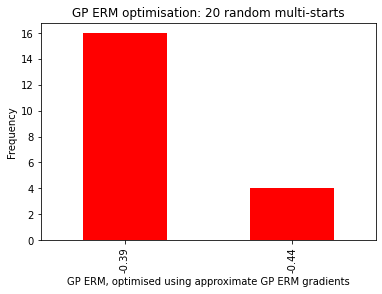

In [15]:
ax = gp_2_20rms.plot.bar(title="GP ERM optimisation: 20 random multi-starts", xlabel="GP ERM, optimised using approximate GP ERM gradients", ylabel="Frequency", color="red")


In [16]:
stp_2_20rms = pd.Series(np.round(stp_2.f_best, 2)).value_counts(sort=True)
stp_2_20rms_df = pd.DataFrame({'Frequency':stp_2_20rms.values,'STP ERM (nu=3)':stp_2_20rms.index})
stp_2_20rms_df


,Frequency,STP ERM (nu=3)
0,16,-8.24
1,4,-8.25


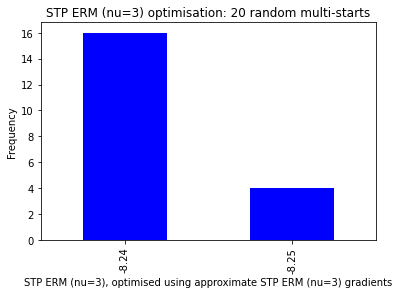

In [17]:
ax = stp_2_20rms.plot.bar(title="STP ERM (nu=3) optimisation: 20 random multi-starts", xlabel="STP ERM (nu=3), optimised using approximate STP ERM (nu=3) gradients", ylabel="Frequency", color="blue")


In [18]:
n_start = 50


In [19]:
### APPROXIMATE GP ERM GRADIENTS: 50 random-multi starts (i.e. 50 rms)

np.random.seed(run_num_2)
surrogate_gp_2_50rms = GaussianProcess(cov_func, optimize=hyperOpt)

gp_2_50rms = GPGO_multi(surrogate_gp_2_50rms, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_2_50rms.run(max_iter = 1, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Min. GP ERM
init	 [-0.38403059 -1.89629507]	 38.61280125654363	 0.011939608840498828	    
init	 [ 0.29797487 -0.25871043]	 0.011939608840498828	 0.011939608840498828	    
init	 [-0.47779319 -0.67866072]	 0.1381453419305213	 0.011939608840498828	    
init	 [-1.7721082   0.47708387]	 0.626144759281101	 0.011939608840498828	    
init	 [-1.20207196 -0.9326909 ]	 3.0693811601417798	 0.011939608840498828	    
1  	 [-0.424761   -0.03918364]	 0.6657976853893743	 0.011939608840498828	 -0.43708342521764754


In [20]:
### APPROXIMATE STP ERM GRADIENTS: 50 random-multi starts (i.e. 50 rms)

np.random.seed(run_num_2)
surrogate_stp_2_50rms = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_2_50rms = GPGO_multi(surrogate_stp_2_50rms, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
stp_2_50rms.run(max_iter = 1, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Min. GP ERM
init	 [-0.38403059 -1.89629507]	 38.61280125654363	 0.011939608840498828	    
init	 [ 0.29797487 -0.25871043]	 0.011939608840498828	 0.011939608840498828	    
init	 [-0.47779319 -0.67866072]	 0.1381453419305213	 0.011939608840498828	    
init	 [-1.7721082   0.47708387]	 0.626144759281101	 0.011939608840498828	    
init	 [-1.20207196 -0.9326909 ]	 3.0693811601417798	 0.011939608840498828	    
1	 [-0.41162007  0.69775429]	 -0.6674580086999173	 -0.6674580086999173	 -8.249117523667486


In [21]:
gp_2_50rms = pd.Series(np.round(gp_2_50rms.f_best, 2)).value_counts(sort=True)
gp_2_50rms_df = pd.DataFrame({'Frequency':gp_2_50rms.values,'GP ERM':gp_2_50rms.index})
gp_2_50rms_df


,Frequency,GP ERM
0,36,-0.39
1,14,-0.44


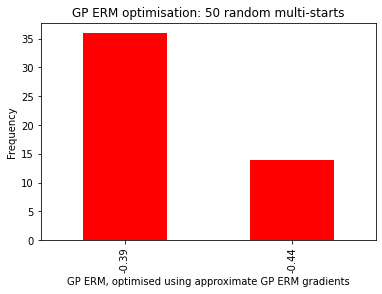

In [22]:
ax = gp_2_50rms.plot.bar(title="GP ERM optimisation: 50 random multi-starts", xlabel="GP ERM, optimised using approximate GP ERM gradients", ylabel="Frequency", color="red")


In [23]:
stp_2_50rms = pd.Series(np.round(stp_2_50rms.f_best, 2)).value_counts(sort=True)
stp_2_50rms_df = pd.DataFrame({'Frequency':stp_2_50rms.values,'STP ERM (nu=3)':stp_2_50rms.index})
stp_2_50rms_df


,Frequency,STP ERM (nu=3)
0,41,-8.24
1,9,-8.25


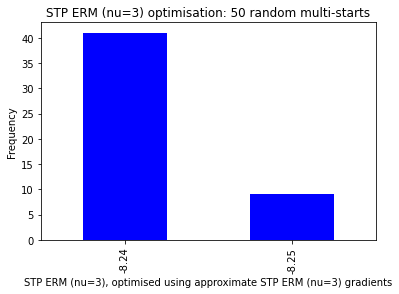

In [24]:
ax = stp_2_50rms.plot.bar(title="STP ERM (nu=3) optimisation: 50 random multi-starts", xlabel="STP ERM (nu=3), optimised using approximate STP ERM (nu=3) gradients", ylabel="Frequency", color="blue")


In [25]:
n_start = 100


In [26]:
### APPROXIMATE GP ERM GRADIENTS: 100 random-multi starts (i.e. 100 rms)

np.random.seed(run_num_2)
surrogate_gp_2_100rms = GaussianProcess(cov_func, optimize=hyperOpt)

gp_2_100rms = GPGO_multi(surrogate_gp_2_100rms, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_2_100rms.run(max_iter = 1, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Min. GP ERM
init	 [-0.38403059 -1.89629507]	 38.61280125654363	 0.011939608840498828	    
init	 [ 0.29797487 -0.25871043]	 0.011939608840498828	 0.011939608840498828	    
init	 [-0.47779319 -0.67866072]	 0.1381453419305213	 0.011939608840498828	    
init	 [-1.7721082   0.47708387]	 0.626144759281101	 0.011939608840498828	    
init	 [-1.20207196 -0.9326909 ]	 3.0693811601417798	 0.011939608840498828	    
1  	 [-0.42476118 -0.03918374]	 0.6657981929860634	 0.011939608840498828	 -0.4370834252176688


In [27]:
### APPROXIMATE STP ERM GRADIENTS: 100 random-multi starts (i.e. 100 rms)

np.random.seed(run_num_2)
surrogate_stp_2_100rms = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_2_100rms = GPGO_multi(surrogate_stp_2_100rms, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
stp_2_100rms.run(max_iter = 1, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Min. GP ERM
init	 [-0.38403059 -1.89629507]	 38.61280125654363	 0.011939608840498828	    
init	 [ 0.29797487 -0.25871043]	 0.011939608840498828	 0.011939608840498828	    
init	 [-0.47779319 -0.67866072]	 0.1381453419305213	 0.011939608840498828	    
init	 [-1.7721082   0.47708387]	 0.626144759281101	 0.011939608840498828	    
init	 [-1.20207196 -0.9326909 ]	 3.0693811601417798	 0.011939608840498828	    
1	 [-0.41162007  0.69775429]	 -0.6674580086999173	 -0.6674580086999173	 -8.249117523667486


In [28]:
gp_2_100rms = pd.Series(np.round(gp_2_100rms.f_best, 2)).value_counts(sort=True)
gp_2_100rms_df = pd.DataFrame({'Frequency':gp_2_100rms.values,'GP ERM':gp_2_100rms.index})
gp_2_100rms_df


,Frequency,GP ERM
0,78,-0.39
1,21,-0.44
2,1,-0.00


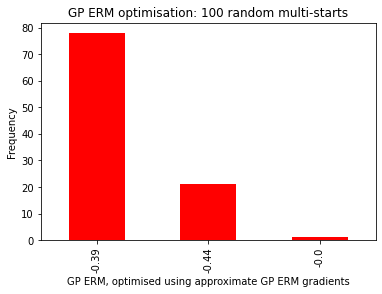

In [29]:
ax = gp_2_100rms.plot.bar(title="GP ERM optimisation: 100 random multi-starts", xlabel="GP ERM, optimised using approximate GP ERM gradients", ylabel="Frequency", color="red")


In [30]:
stp_2_100rms = pd.Series(np.round(stp_2_100rms.f_best, 2)).value_counts(sort=True)
stp_2_100rms_df = pd.DataFrame({'Frequency':stp_2_100rms.values,'STP ERM (nu=3)':stp_2_100rms.index})
stp_2_100rms_df


,Frequency,STP ERM (nu=3)
0,84,-8.24
1,16,-8.25


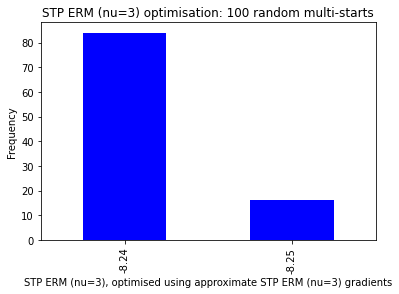

In [31]:
ax = stp_2_100rms.plot.bar(title="STP ERM (nu=3) optimisation: 100 random multi-starts", xlabel="STP ERM (nu=3), optimised using approximate STP ERM (nu=3) gradients", ylabel="Frequency", color="blue")


In [32]:
print(gp_2_20rms.to_latex(index=True))


\begin{tabular}{lr}
\toprule
{} &   0 \\
\midrule
-0.39 &  16 \\
-0.44 &   4 \\
\bottomrule
\end{tabular}



In [33]:
print(stp_2_20rms.to_latex(index=True))


\begin{tabular}{lr}
\toprule
{} &   0 \\
\midrule
-8.24 &  16 \\
-8.25 &   4 \\
\bottomrule
\end{tabular}



In [34]:
print(gp_2_50rms.to_latex(index=True))


\begin{tabular}{lr}
\toprule
{} &   0 \\
\midrule
-0.39 &  36 \\
-0.44 &  14 \\
\bottomrule
\end{tabular}



In [35]:
print(stp_2_50rms.to_latex(index=True))


\begin{tabular}{lr}
\toprule
{} &   0 \\
\midrule
-8.24 &  41 \\
-8.25 &   9 \\
\bottomrule
\end{tabular}



In [36]:
print(gp_2_100rms.to_latex(index=True))


\begin{tabular}{lr}
\toprule
{} &   0 \\
\midrule
-0.39 &  78 \\
-0.44 &  21 \\
-0.00 &   1 \\
\bottomrule
\end{tabular}



In [37]:
print(stp_2_100rms.to_latex(index=True))


\begin{tabular}{lr}
\toprule
{} &   0 \\
\midrule
-8.24 &  84 \\
-8.25 &  16 \\
\bottomrule
\end{tabular}



In [38]:
### Synthetic function for testing i.e. y = sine(x):

def objfunc(x1_training):                       # Define synthetic function
        return  operator * np.sin(x1_training)
                          
def objfunc_der(x1_training):                   # Define synthetic function's true first-order derivative i.e. gradient
        return  operator * np.cos(x1_training)

# Constraints:
lb = 0                                          # Lower-bound of synthetic function's input x vector (1-D)
ub = 2 * np.pi                                  # Upper-bound of synthetic function's input x vector (1-D)
    
# Input array dimension(s):                     # 1-D problem
dim = 1

# 1-D inputs' parameter bounds:                 # 1-D bounds' parameter object
param = {'x1_training': ('cont', [lb, ub])}

# True y bounds:
operator = 1                                  # Can toggle between seeking the synthetic's minimum versus maximum
y_global_orig = 1                             # Maximum for y = sine(x)

# Test data:
x1_test = np.linspace(lb, ub, n_test)         # Define test data object
x_test = np.column_stack((x1_test)).T         # Transposed for algebraic reasons

seed = 1                                      # Re-producability term for randomized initialization


In [39]:
### Plot Gaussian surrogate + acquisition: y = sine(x):

def plot_Gaussian(gpgo, param, new=True):
    x_test = np.linspace(lb, ub, n_test).reshape((n_test, 1))
    x_test_h = x_test + eps
    y_hat, y_var = gpgo.GP.predict(x_test, return_std=True)
    std = np.sqrt(y_var)
    l, u = y_hat - 1.96 * std, y_hat + 1.96 * std
    colours = ['Post', 'Random']
    a = np.array([gpgo._acqWrapper(np.atleast_1d(x))[0] for x in x_test]).flatten()
    if new:
        fig = plt.figure(figsize=(10,7))
        r = fig.add_subplot(2, 1, 1)
        plt.scatter(gpgo.GP.X, gpgo.GP.y, marker ='D', color = 'Red', label='Function evaluation point: ($\mathbf{x}$, $y$)')
        plt.scatter(gpgo.X, gpgo.y, marker ='D', color = 'Green', label='Random-initialisation point: ($\mathbf{x}$, $y$)')
        plt.ylim(-2, 2)
        plt.xlim(0,2 * np.pi)
        plt.plot(x_test.flatten(), operator * objfunc(x_test.flatten()), color = 'Yellow', label='Objective function: $y$ = sin($\mathbf{x}$)')
        plt.plot(x_test.flatten(), y_hat, color = 'Orange', ls = '--', label='GP posterior mean: $\hat{y} = \mu_{GP}(\mathbf{x})$')
        plt.fill_between(x_test.flatten(), l, u, alpha=0.2, label='95% Confidence Interval for $\hat{\mu}_{GP}(\mathbf{x})$')
        plt.axvline(x=x_test[np.argmin(a)], color='Brown', ls = '--', label='GP ERM: arg min $\mathbf{x}$')
        ###plt.legend(loc=0)
        title = 'GP ERM, optimised with approximate GP ERM gradients'
        r.set_title(title, weight = 'bold')
        plt.xlabel("$\mathbf{x}$")
        plt.ylabel("sin($\mathbf{x}$), $\hat{\mu}_{GP}(\mathbf{x})$")
        r = fig.add_subplot(2, 1, 2)
        plt.plot(x_test, a, color='Purple', label='GP ERM $(\mathbf{x})$')
        plt.axvline(x=x_test[np.argmin(a)], color='Brown', ls = '--', label='GP ERM: arg min $\mathbf{x}$')
        plt.legend(loc=0)
        plt.xlim(0,2 * np.pi)
        plt.xlabel("$\mathbf{x}$")
        plt.ylabel("GP ERM $(\mathbf{x})$")
        plt.show()
        

In [40]:
### Plot Student's-t surrogate + acquisition: y = sine(x):

def plot_Student(gpgo, param, new=True):
    x_test = np.linspace(lb, ub, n_test).reshape((n_test, 1))
    x_test_h = x_test + eps
    y_hat, y_var = gpgo.GP.predict(x_test, return_std=True)
    std = np.sqrt(y_var)
    l, u = y_hat - 3.182 * std, y_hat + 3.182 * std # t-score, 3 DF, 95% confidence (two-tail)
    a = np.array([gpgo._acqWrapper(np.atleast_1d(x))[0] for x in x_test]).flatten()
    colours = ['Post', 'Random']
    if new:
        fig = plt.figure(figsize=(10,7))
        r = fig.add_subplot(2, 1, 1)
        plt.scatter(gpgo.GP.X, gpgo.GP.y, marker ='D', color = 'Red', label='Function evaluation point: ($\mathbf{x}$, $y$)')
        plt.scatter(gpgo.X, gpgo.y, marker ='D', color = 'Green', label='Random-initialisation point: ($\mathbf{x}$, $y$)')
        plt.ylim(-3, 3)
        plt.xlim(0,2 * np.pi)
        plt.plot(x_test.flatten(), operator * objfunc(x_test.flatten()), color = 'Yellow', label='Objective function: $y$ = sin($\mathbf{x}$)')
        plt.plot(x_test.flatten(), y_hat, color = 'Orange', ls = '--', label='STP (nu=3) posterior mean: $\hat{y} = \mu_{STP}(\mathbf{x})$')
        plt.fill_between(x_test.flatten(), l, u, alpha=0.2, label='95% Confidence Interval for $\hat{\mu}_{STP}(\mathbf{x})$')
        plt.axvline(x=x_test[np.argmin(a)], color='Brown', label='STP (nu=3) ERM: arg min $\mathbf{x}$')
        ###plt.legend(loc=0)
        title = 'STP (nu=3) CBM, optimised with approximate STP (nu=3) ERM gradients'
        r.set_title(title, weight = 'bold')
        plt.xlabel("$\mathbf{x}$")
        plt.ylabel("sin($\mathbf{x}$), $\hat{\mu}_{STP}(\mathbf{x})$")
        r = fig.add_subplot(2, 1, 2)
        plt.plot(x_test, a, color='Purple', ls = '--', label='STP (nu=3) ERM $(\mathbf{x})$')
        plt.axvline(x=x_test[np.argmin(a)], color='Brown', label='STP (nu=3) ERM: arg min $\mathbf{x}$')
        plt.legend(loc=4)
        plt.xlim(0,2 * np.pi)
        plt.xlabel("$\mathbf{x}$")
        plt.ylabel("STP (nu=3) CBM$(\mathbf{x})$")
        plt.show()


In [41]:
### Approximate GP ERM gradients: Sine 1st function evaluation

n_init = 3
iters = 1

np.random.seed(seed)
surrogate_approx_gp1 = GaussianProcess(cov_func, optimize=hyperOpt)

approx_gp1 = GPGO_multi(surrogate_approx_gp1, Acquisition_new(util_gp), objfunc, param)
approx_gp1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Min. GP ERM
init	 [2.62022653]	 -0.4980652197092493	 -0.4980652197092493	    
init	 [4.52593227]	 0.9826672516685445	 -0.4980652197092493	    
init	 [0.00071864]	 -0.0007186381099970609	 -0.4980652197092493	    
1  	 [2.68145543]	 -0.4440710631951975	 -0.4980652197092493	 -0.022650504007748484


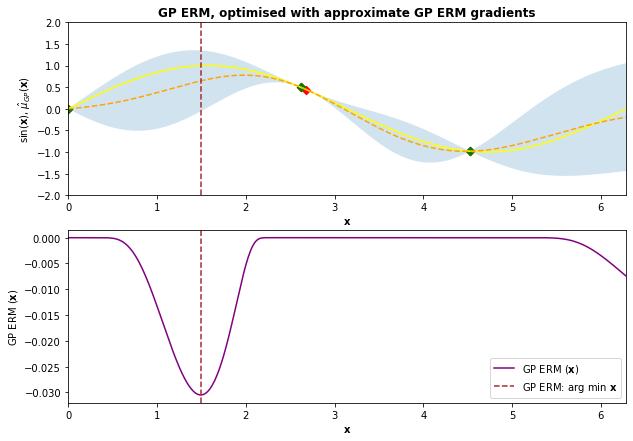

In [42]:
plot_Gaussian(approx_gp1, param, new=True)


In [43]:
### Approximate GP ERM gradients: Sine 2nd function evaluation

np.random.seed(seed)
surrogate_approx_gp2 = GaussianProcess(cov_func, optimize=hyperOpt)

approx_gp2 = GPGO_multi(surrogate_approx_gp2, Acquisition_new(util_gp), objfunc, param)
approx_gp2.run(init_evals=n_init, max_iter=iters+1)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Min. GP ERM
init	 [2.62022653]	 -0.4980652197092493	 -0.4980652197092493	    
init	 [4.52593227]	 0.9826672516685445	 -0.4980652197092493	    
init	 [0.00071864]	 -0.0007186381099970609	 -0.4980652197092493	    
1  	 [2.68145543]	 -0.4440710631951975	 -0.4980652197092493	 -0.022650504007748484
2	 [1.49462441]	 -0.9971003216424693	 -0.9971003216424693	 -0.030490477224570586


In [44]:
### Approximate STP ERM gradients: Sine 1st function evaluation

np.random.seed(seed)
surrogate_approx_stp1 = tStudentProcess(cov_func, optimize=hyperOpt, nu=df)

approx_stp1 = GPGO_multi_STP(surrogate_approx_stp1, Acquisition_new(util_stp), objfunc, param)
approx_stp1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Min. STP ERM (nu=3)
init	 [2.62022653]	 -0.4980652197092493	 -0.4980652197092493	    
init	 [4.52593227]	 0.9826672516685445	 -0.4980652197092493	    
init	 [0.00071864]	 -0.0007186381099970609	 -0.4980652197092493	    
1	 [2.29706217]	 -0.7476593942390578	 -0.7476593942390578	 -0.09347523176897475


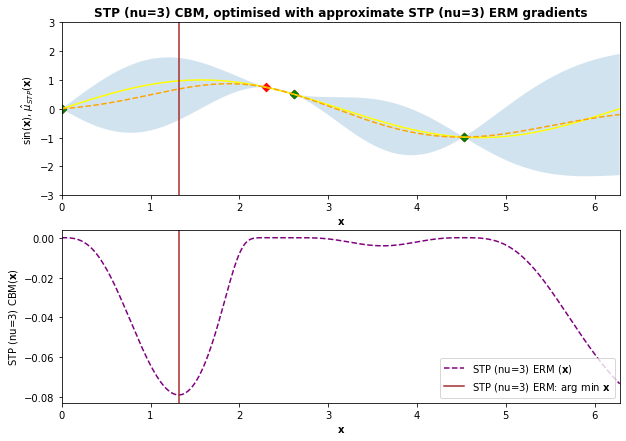

In [45]:
plot_Student(approx_stp1, param, new=True)


In [46]:
### Approximate STP ERM gradients: Sine 2nd function evaluation

np.random.seed(seed)
surrogate_approx_stp2 = tStudentProcess(cov_func, optimize=hyperOpt, nu=df)

approx_stp2 = GPGO_multi_STP(surrogate_approx_stp2, Acquisition_new(util_stp), objfunc, param)
approx_stp2.run(init_evals=n_init, max_iter=iters+1)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Min. STP ERM (nu=3)
init	 [2.62022653]	 -0.4980652197092493	 -0.4980652197092493	    
init	 [4.52593227]	 0.9826672516685445	 -0.4980652197092493	    
init	 [0.00071864]	 -0.0007186381099970609	 -0.4980652197092493	    
1	 [2.29706217]	 -0.7476593942390578	 -0.7476593942390578	 -0.09347523176897475
2	 [1.31773703]	 -0.9681510072019921	 -0.9681510072019921	 -0.07884525222697943
